# EDA

# 1. wczytanie danych i bibliotek

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv("../data/to_model/new_york_listings_2024_to_model.csv");
data.head()

id                                               name  \
0  718037328155265207  Rental unit in Queens · 5 bedrooms · 8 beds · ...   
1             5536638  Rental unit in Brooklyn · ★4.60 · 2 bedrooms ·...   
2             4605840  Rental unit in Brooklyn · ★4.93 · 1 bedroom · ...   
3  594240338554500815  Rental unit in New York · 1 bedroom · 1 bed · ...   
4               26785  Rental unit in Brooklyn · ★4.93 · 1 bedroom · ...   

     host_id      host_name neighbourhood_group       neighbourhood  latitude  \
0     204539           Mark              Queens           Ridgewood  40.70262   
1   28709982          Sidiq            Brooklyn        Williamsburg  40.72027   
2   23788242        Suzanne            Brooklyn  Bedford-Stuyvesant  40.68670   
3  384559808  Best Inns USA           Manhattan        East Village  40.73221   
4      42273           Dani            Brooklyn         South Slope  40.66860   

   longitude        room_type  price  ...  last_review  reviews_per_month  \
0  -73.89800  Entire home/apt  471.0  ...   2022-11-03               0.07   
1  -73.95513  Entire home/apt  225.0  ...   2023-09-13               0.49   
2  -73.94856     Private room   80.0  ...   2023-11-17               1.00   
3  -73.98689  Entire home/apt   83.0  ...   2023-08-11               0.12   
4  -73.98723  Entire home/apt   90.0  ...   2022-05-31               2.90   

  calculated_host_listings_count  availability_365  number_of_reviews_ltm  \
0                              9               365                      0   
1                              5                90                      7   
2                              2               363                     12   
3                             30               106                      1   
4                              3               188                      0   

      license     rating bedrooms beds baths  
0  No License  No rating        5    8     2  
1  No License      4.60         2    2     1  
2  No License      4.93         1    1     1  
3  No License  No rating        1    1     1  
4  No License      4.93         1    1     1  

[5 rows x 22 columns]

Z opisu ramki na kaggle wynika, że autor zrobił już część rzeczy za nas (np. wyekstrachował rating z kolumny name).  
Dane orginalnie pochodzą ze strony: [źródło](https://insideairbnb.com/get-the-data/), a znaczenie kolumn można znaleźć w pliku: [oznaczenia](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596) (ze strony airbnb)

### sprawdzenie podsatwowych informacji o ramce

In [3]:
data.shape

(16606, 22)

Mamy 1606 wierszy i 22 kolumny.

Kolumny, które wymagają wytłumaczenia:
- room_type - [Entire home/apt|Private room|Shared room|Hotel]
- last_review - data ostatniej recenzji
- calculated_host_listings_count - liczba ogłoszeń, które dany host ma w danym mieście (w tym wypadku zakładam NY)
- availability_365 - liczba dni w najbliższym roku, w które można coś sobie zabookować (reszta dni może być zajęta, ponieważ ktoś inny już zabookował termin, ale też, bo host mógł dany termin zablokować)
- number_of_reviews_ltm - liczba opinii o ogłoszeniu z ostatnich 12 miesięcy (warto zaznaczyć, że dane pochodzą z 5 stycznia 2024 roku)
- beds/baths/bedrooms - liczba łóżek/...  

#### wartości Null w ramce

In [4]:
data.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
license                           0
rating                            0
bedrooms                          0
beds                              0
baths                             0
dtype: int64

Brak nulli :)

####  informacje o kolumnach

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16606 entries, 0 to 16605
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              16606 non-null  int64  
 1   name                            16606 non-null  object 
 2   host_id                         16606 non-null  int64  
 3   host_name                       16606 non-null  object 
 4   neighbourhood_group             16606 non-null  object 
 5   neighbourhood                   16606 non-null  object 
 6   latitude                        16606 non-null  float64
 7   longitude                       16606 non-null  float64
 8   room_type                       16606 non-null  object 
 9   price                           16606 non-null  float64
 10  minimum_nights                  16606 non-null  int64  
 11  number_of_reviews               16606 non-null  int64  
 12  last_review                     

Zobaczyć można, że niektóre kolumny mają dziwne typy, np zamiast inta bedrooms i baths mają object (zawierają jakieś stringi czasami). Będzie to trzeba naprawić i w tym celu zobaczmy jak to wygląda "od środka"

In [6]:
import re

def contains_only_numbers_and_dots(s):
    pattern = r"^[0-9.]+$"
    return re.match(pattern, s.strip()) is not None

In [7]:
print(data["rating"][0])
contains_only_numbers_and_dots(data["rating"][0])

No rating


False

Sprawdzmy jakie inne wartości od liczbowych są w rating, beds i baths
Trzeba będzie się zastanowić potem co zrobić z tym jak oznaczyć te stringi jako liczby lub wgl co z tym zrobić

In [8]:
to_check = ["rating", "bedrooms", "baths"]
for i in to_check:
    series = data[i].loc[~data[i].apply(contains_only_numbers_and_dots)]
    print(series.value_counts())
    print("------------------------------")

rating
No rating    2865
New           135
Name: count, dtype: int64
------------------------------
bedrooms
Studio    1438
Name: count, dtype: int64
------------------------------
baths
Not specified    12
Name: count, dtype: int64
------------------------------


Wsm to zobaczmy te wiersze co mają baths == not specified

In [9]:
data.loc[data["baths"]=="Not specified"]["name"] # No możemy na spokojnie założyć teraz, że shared baths zaliczają sie do baths

67              Rental unit in Brooklyn · ★5.0 · 1 bedroom
166      Rental unit in New York · ★4.59 · Studio · 2 beds
4697     Rental unit in New York · ★4.17 · 1 bedroom · ...
6008                Townhouse in Brooklyn · ★4.87 · Studio
8626                    Home in Queens · ★4.74 · 1 bedroom
9829     Rental unit in Brooklyn · ★4.52 · 1 bedroom · ...
12497          Boutique hotel in New York · Studio · 1 bed
12921         Home in Brooklyn · ★4.96 · 1 bedroom · 1 bed
13012    Rental unit in New York · ★4.86 · 1 bedroom · ...
14569                   Hotel in New York · Studio · 1 bed
15425                  Rental unit in Brooklyn · 1 bedroom
15807          Rental unit in Brooklyn · 1 bedroom · 1 bed
Name: name, dtype: object

In [10]:
# Co jest zawarte w name (Można odpalić parę razy)
for i in range(20):
    print(data["name"][random.randint(0, data.shape[0] - 1)])

Rental unit in The Bronx · 1 bedroom · 1 bed · 2 baths
Rental unit in New York · 2 bedrooms · 2 beds · 1 bath
Boutique hotel in New York · ★4.69 · 1 bedroom · 1 bed · 1 bath
Boutique hotel in New York · 1 bedroom · 1 bed · 1 shared bath
Rental unit in Brooklyn · ★4.82 · 3 bedrooms · 3 beds · 1 bath
Rental unit in Brooklyn · ★4.60 · 1 bedroom · 1 bed · 1 bath
Rental unit in Brooklyn · ★4.57 · 1 bedroom · 1 bed · 1 bath
Home in Queens · ★4.67 · 2 bedrooms · 3 beds · 1.5 baths
Townhouse in Brooklyn · ★4.92 · 1 bedroom · 1 bed · 1.5 baths
Home in Bronx  · 1 bedroom · 2 beds · 1 shared bath
Home in Brooklyn · ★4.96 · 1 bedroom · 1 bed · 1 private bath
Townhouse in Brooklyn · ★4.33 · 1 bedroom · 1 bed · 2.5 shared baths
Condo in Brooklyn  · ★4.92 · 1 bedroom · 1 bed · 1 shared bath
Rental unit in New York · 1 bedroom · 1 bed · 1 shared bath
Rental unit in Brooklyn · ★4.96 · Studio · 1 bed · 1 bath
Guest suite in Bronx · ★4.86 · 1 bedroom · 1 bed · 1 shared bath
Rental unit in Bronx · ★5.0 · 

### wstepne wnioski o tym ktore kolumny warto zostawić

- id - raczej nie ma sensu zostawiać, bo to raczej nie jest cecha, która ma wpływ na cenę

Zostawilibysmy jednak kolumny name i host_name/id jako, że:
- Jestem ciekawy czy jeśli łazienka jest zaznaczona w name jako "shared" to będzie doliczona do łazienkek itp (edit. tak są)
- Pierwsze 1/2 słowa nie są zapisane nigdzie jako cecha, nie wiem czy warto się tym interesować (edit. uznałem, że nie warto)
- Host_name zawiera właściciela. Czasem na airbnb nie człowiek, a firma wynajmuje lokum. Zatem można zostawić to też jeszcze, bo może to nam dać później jakieś odniesienie (edit. porzuciłem)

In [11]:
# przyjrzyjmy się host_id
data["host_id"].value_counts() # widać, ze jednak nie ma wiele firm dających na airbnb możliwość wynajęcia (czyli można wywalać potem)

host_id
51501835     107
162280872    103
61391963      96
107434423     81
19303369      72
            ... 
151692758      1
110346058      1
1388987        1
274605727      1
478704134      1
Name: count, Length: 10458, dtype: int64

ostatecznie porzucimy name, host_name i host_id

In [12]:
data = data.drop(["id"], axis = 1)
data = data.drop(["name", "host_id", "host_name"], axis = 1)
data

neighbourhood_group       neighbourhood   latitude  longitude  \
0                  Queens           Ridgewood  40.702620 -73.898000   
1                Brooklyn        Williamsburg  40.720270 -73.955130   
2                Brooklyn  Bedford-Stuyvesant  40.686700 -73.948560   
3               Manhattan        East Village  40.732210 -73.986890   
4                Brooklyn         South Slope  40.668600 -73.987230   
...                   ...                 ...        ...        ...   
16601            Brooklyn  Bedford-Stuyvesant  40.686001 -73.943693   
16602              Queens              Corona  40.745100 -73.864880   
16603               Bronx            Allerton  40.867770 -73.860180   
16604           Manhattan              Harlem  40.830791 -73.949509   
16605           Manhattan             Midtown  40.762250 -73.978280   

             room_type  price  minimum_nights  number_of_reviews last_review  \
0      Entire home/apt  471.0              30                  1  2022-11-03   
1      Entire home/apt  225.0              30                 52  2023-09-13   
2         Private room   80.0              30                101  2023-11-17   
3      Entire home/apt   83.0              30                  2  2023-08-11   
4      Entire home/apt   90.0              30                479  2022-05-31   
...                ...    ...             ...                ...         ...   
16601  Entire home/apt  135.0              30                 15  2023-01-10   
16602     Private room   68.0              30                 16  2023-10-16   
16603  Entire home/apt  100.0              30                 30  2023-10-07   
16604     Private room   50.0              30                 19  2023-12-10   
16605  Entire home/apt  130.0              30                  2  2023-06-01   

       reviews_per_month  calculated_host_listings_count  availability_365  \
0                   0.07                               9               365   
1                   0.49                               5                90   
2                   1.00                               2               363   
3                   0.12                              30               106   
4                   2.90                               3               188   
...                  ...                             ...               ...   
16601               0.97                               1               262   
16602               2.68                               2               180   
16603               2.21                               5               365   
16604               0.21                               4                42   
16605               0.20                               5               365   

       number_of_reviews_ltm     license     rating bedrooms  beds baths  
0                          0  No License  No rating        5     8     2  
1                          7  No License      4.60         2     2     1  
2                         12  No License      4.93         1     1     1  
3                          1  No License  No rating        1     1     1  
4                          0  No License      4.93         1     1     1  
...                      ...         ...        ...      ...   ...   ...  
16601                      1  No License      4.87         3     3     1  
16602                     16  No License      4.69         1     1     1  
16603                     24  No License      4.73         1     1     1  
16604                      1  No License      4.84         1     1   1.5  
16605                      2  No License  No rating        1     1     1  

[16606 rows x 18 columns]

#### przyjrzyjmy się wartościom w kolumnach

In [13]:
data.describe()

latitude     longitude          price  minimum_nights  \
count  16606.000000  16606.000000   16606.000000    16606.000000   
mean      40.726740    -73.939112     190.328074       28.619716   
std        0.060366      0.061366    1134.545935       35.219921   
min       40.500314    -74.249840      10.000000        1.000000   
25%       40.684119    -73.980840      80.000000       30.000000   
50%       40.722935    -73.949650     125.000000       30.000000   
75%       40.763025    -73.917362     199.000000       30.000000   
max       40.911147    -73.713650  100000.000000     1250.000000   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
count       16606.000000       16606.000000                    16606.000000   
mean           42.664158           1.256612                       18.554077   
std            74.116856           1.903427                       69.620276   
min             1.000000           0.010000                        1.000000   
25%             4.000000           0.210000                        1.000000   
50%            14.000000           0.650000                        2.000000   
75%            49.000000           1.800000                        5.000000   
max          1865.000000          75.490000                      713.000000   

       availability_365  number_of_reviews_ltm         beds  
count      16606.000000           16606.000000  16606.00000  
mean         205.954113              10.804649      1.72799  
std          135.066607              21.126468      1.22619  
min            0.000000               0.000000      1.00000  
25%           87.000000               1.000000      1.00000  
50%          214.000000               3.000000      1.00000  
75%          354.000000              15.000000      2.00000  
max          365.000000            1075.000000     42.00000

Z ciekawych rzeczy mozna spojrzec na:
- maksymalną cene za noc (100 000$ !) 
- ludzie z NY jako, że miasto raczej nie jest wypoczynkowe wynajmują poprzez airbnb lokum ludziom głównie w celach jakiejś pracy czy innych dłuższych postojów (>50\% napewno, wystarczy spojrzeć na kwantyle w minimum_nights)

#### Przyjrzyjmy sie kolumnie license - binujemy ją na 0 i 1

In [14]:
data["license"].value_counts()  # Trzeba zbinować do jednej grupy poza no license i exemp

license
No License            14057
Exempt                 1702
OSE-STRREG-0000068       10
OSE-STRREG-0008664        6
OSE-STRREG-0000003        4
                      ...  
OSE-STRREG-0000152        1
OSE-STRREG-0000424        1
OSE-STRREG-0000956        1
OSE-STRREG-0000387        1
OSE-STRREG-0000341        1
Name: count, Length: 725, dtype: int64

In [15]:
def lic_mapper(a):
    if a == "No License" or a == "Exempt":
        return 0
    else:
        return 1


data["license"] = data["license"].map(lic_mapper)  # Jeśli ma licencję to 1, jeśli nie to 0
data["license"].value_counts()

license
0    15759
1      847
Name: count, dtype: int64

# 2. Pierwsze wykresy

## 2.1 Numeryczne
na wykresach odcinamy 5% największych wartości, bo inaczej wykresy są tragiczne

In [16]:
numerical = ["price", "minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count", "availability_365", "number_of_reviews_ltm", "beds"]
hidden_numerical = ["rating", "bedrooms", "baths"]

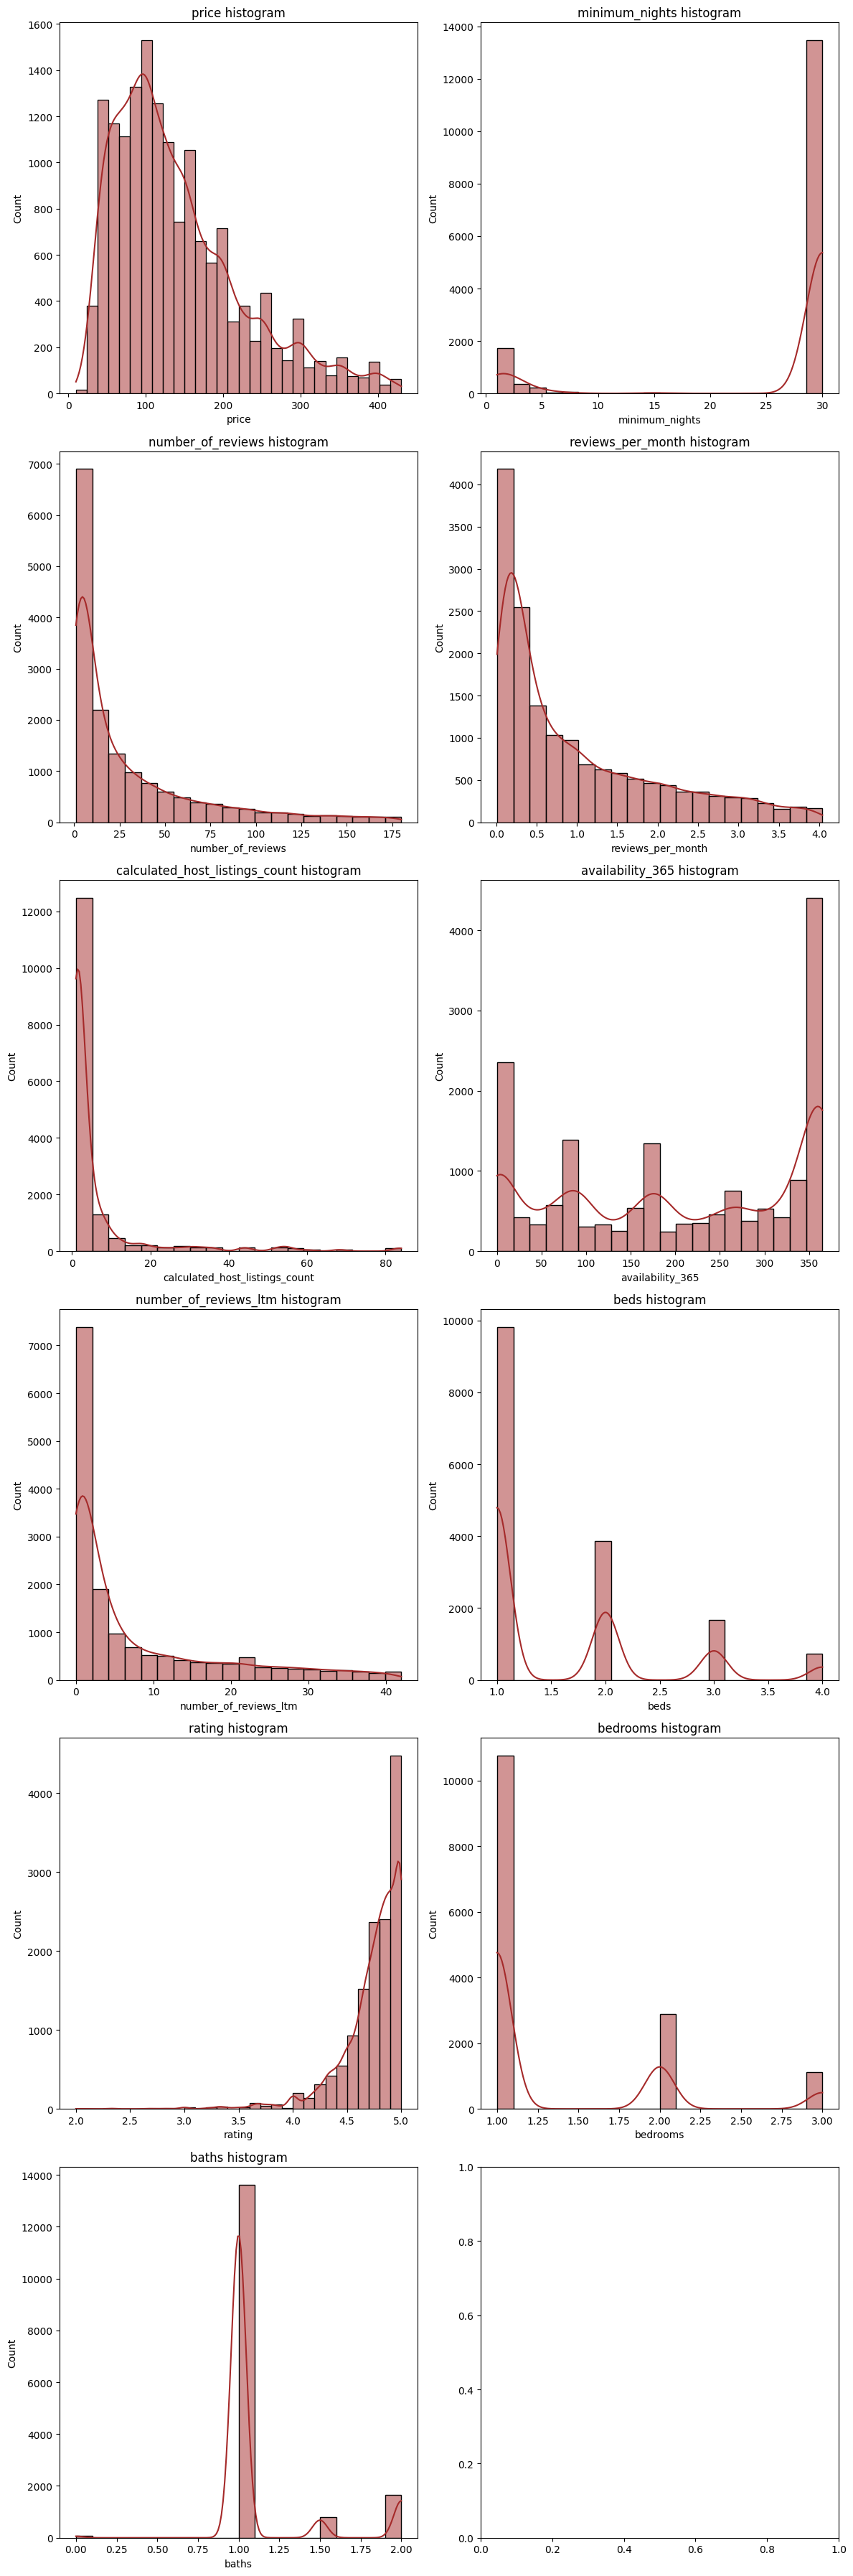

In [17]:
# Odcięte 5% największych obserwacji (inaczej wykresy są tragiczne)
fig, axs = plt.subplots(6, 2, figsize = (12, 36))
axs = axs.flatten()

bins = [30, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20]
# nasze numeryczne
for i, col in enumerate(numerical):
    series = data[col].loc[data[col] <= np.quantile(data[col], 0.95)]
    sns.histplot(x = series, ax=axs[i], color = "brown", kde = True, bins=bins[i]).set(title = col + " histogram")

# te ze stringami
for i, col in enumerate(hidden_numerical):
    series = data[col].loc[data[col].apply(contains_only_numbers_and_dots)].apply(float)
    series = series.loc[series <= np.quantile(series, 0.95)]
    sns.histplot(x = series, ax=axs[8+i], color = "brown", kde = True, bins = bins[i+8]).set(title = col + " histogram")
plt.tight_layout()
plt.show()

Co oznacza 1.5 łazienki?? (Potem będę to castował do jednej najprawdopodobniej)

### Outliery

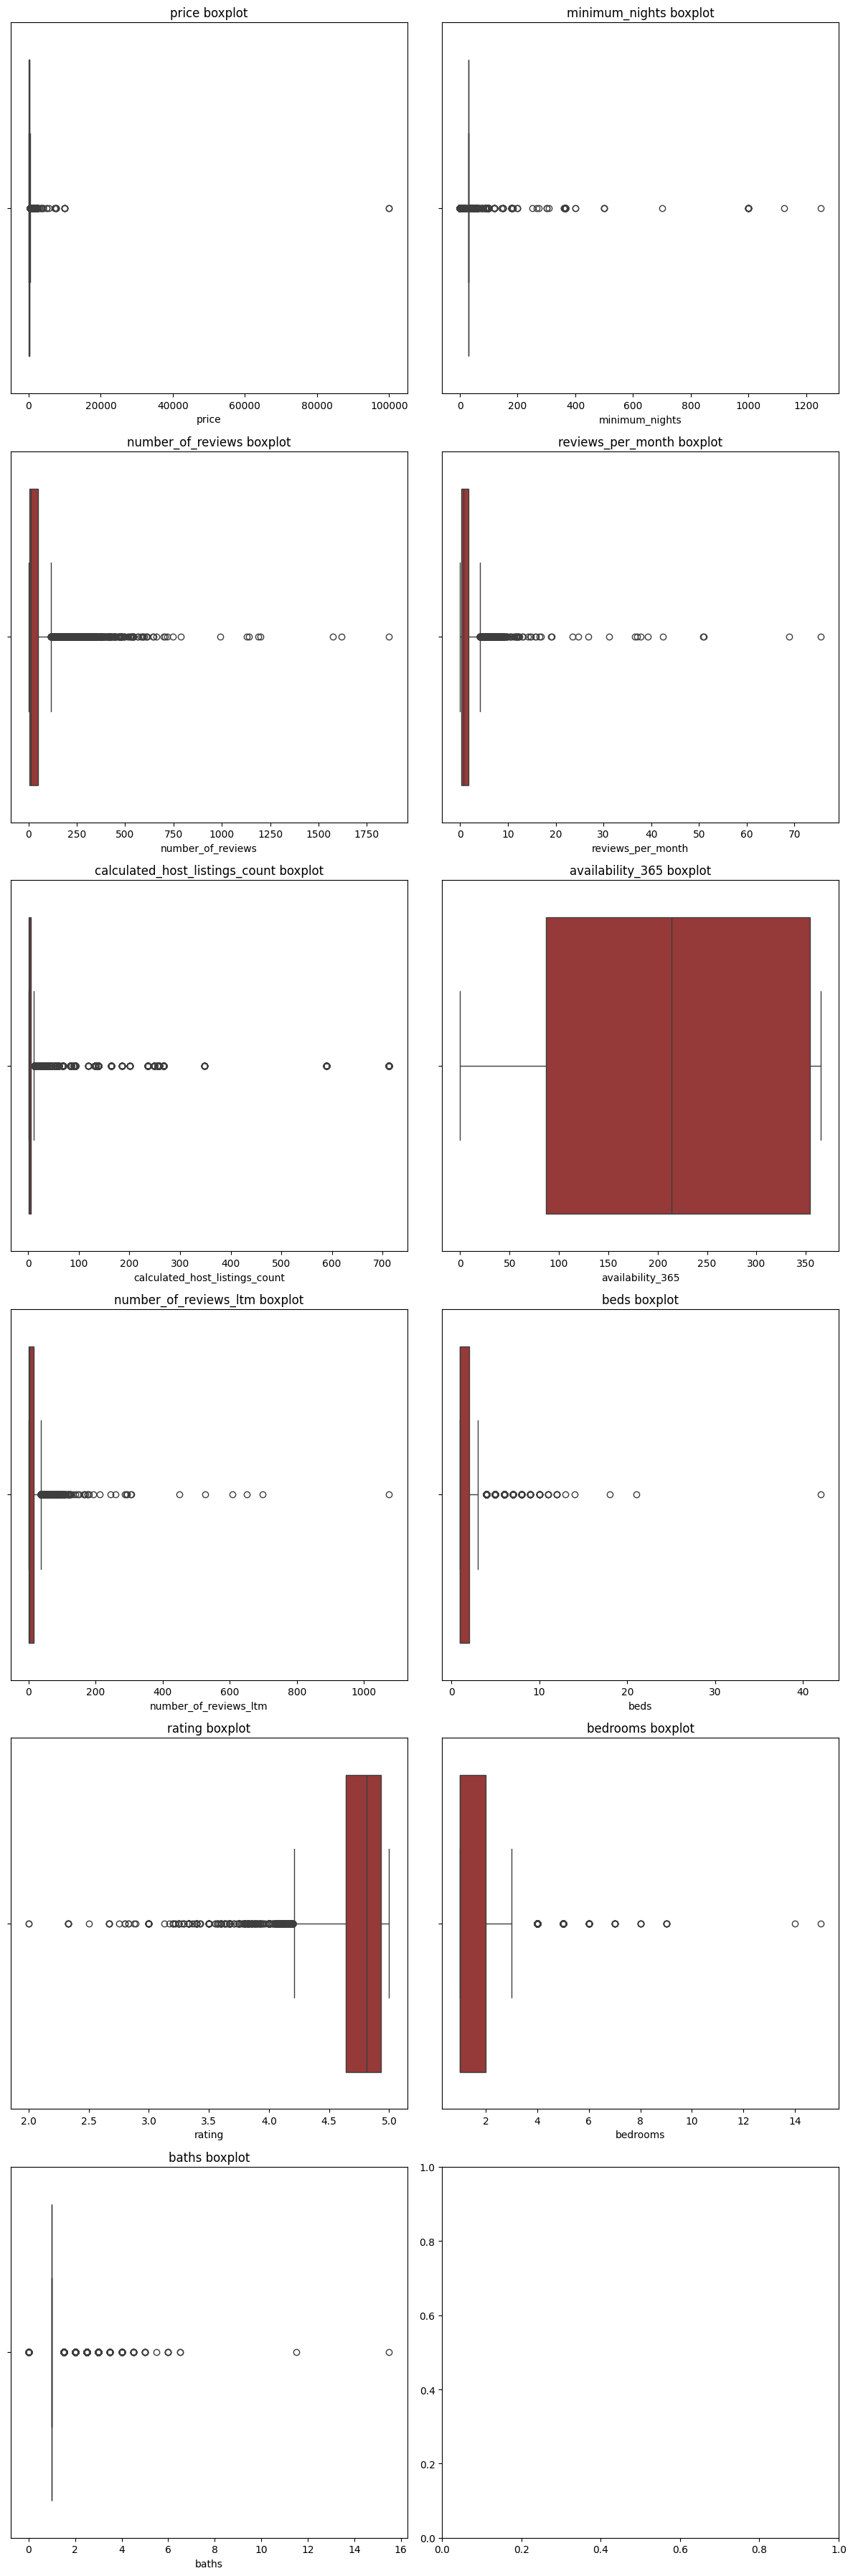

In [18]:
fig, axs = plt.subplots(6, 2, figsize = (12, 36))
axs = axs.flatten()

# nasze numeryczne
for i, col in enumerate(numerical):
    sns.boxplot(data = data, x = col, ax=axs[i], color = "brown").set(title = col + " boxplot")

# te ze stringami
for i, col in enumerate(hidden_numerical):
    series = data[col].loc[data[col].apply(contains_only_numbers_and_dots)].apply(float)
    sns.boxplot(x = series, ax=axs[8+i], color = "brown").set(title = col + " boxplot")
plt.tight_layout()
plt.show()

Widzimy, że będzie problem z outlierami, ale tym zajmiemy się przy kolejnych etapach

## 2.2 Nienumerycze

In [19]:
data.columns.difference(numerical)

Index(['baths', 'bedrooms', 'last_review', 'latitude', 'license', 'longitude',
       'neighbourhood', 'neighbourhood_group', 'rating', 'room_type'],
      dtype='object')

In [20]:
nonumerical = ['license', 'neighbourhood', 'neighbourhood_group', 'room_type']

In [21]:
# Funkcja pomocnicza do pokazywania procentów
def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.2
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

In [22]:
data["neighbourhood"].isin(data["neighbourhood"].value_counts()[data["neighbourhood"].value_counts()>30].index)

0         True
1         True
2         True
3         True
4         True
         ...  
16601     True
16602     True
16603    False
16604     True
16605     True
Name: neighbourhood, Length: 16606, dtype: bool

C:\Users\Bartek\AppData\Local\Temp\ipykernel_19344\965181376.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')


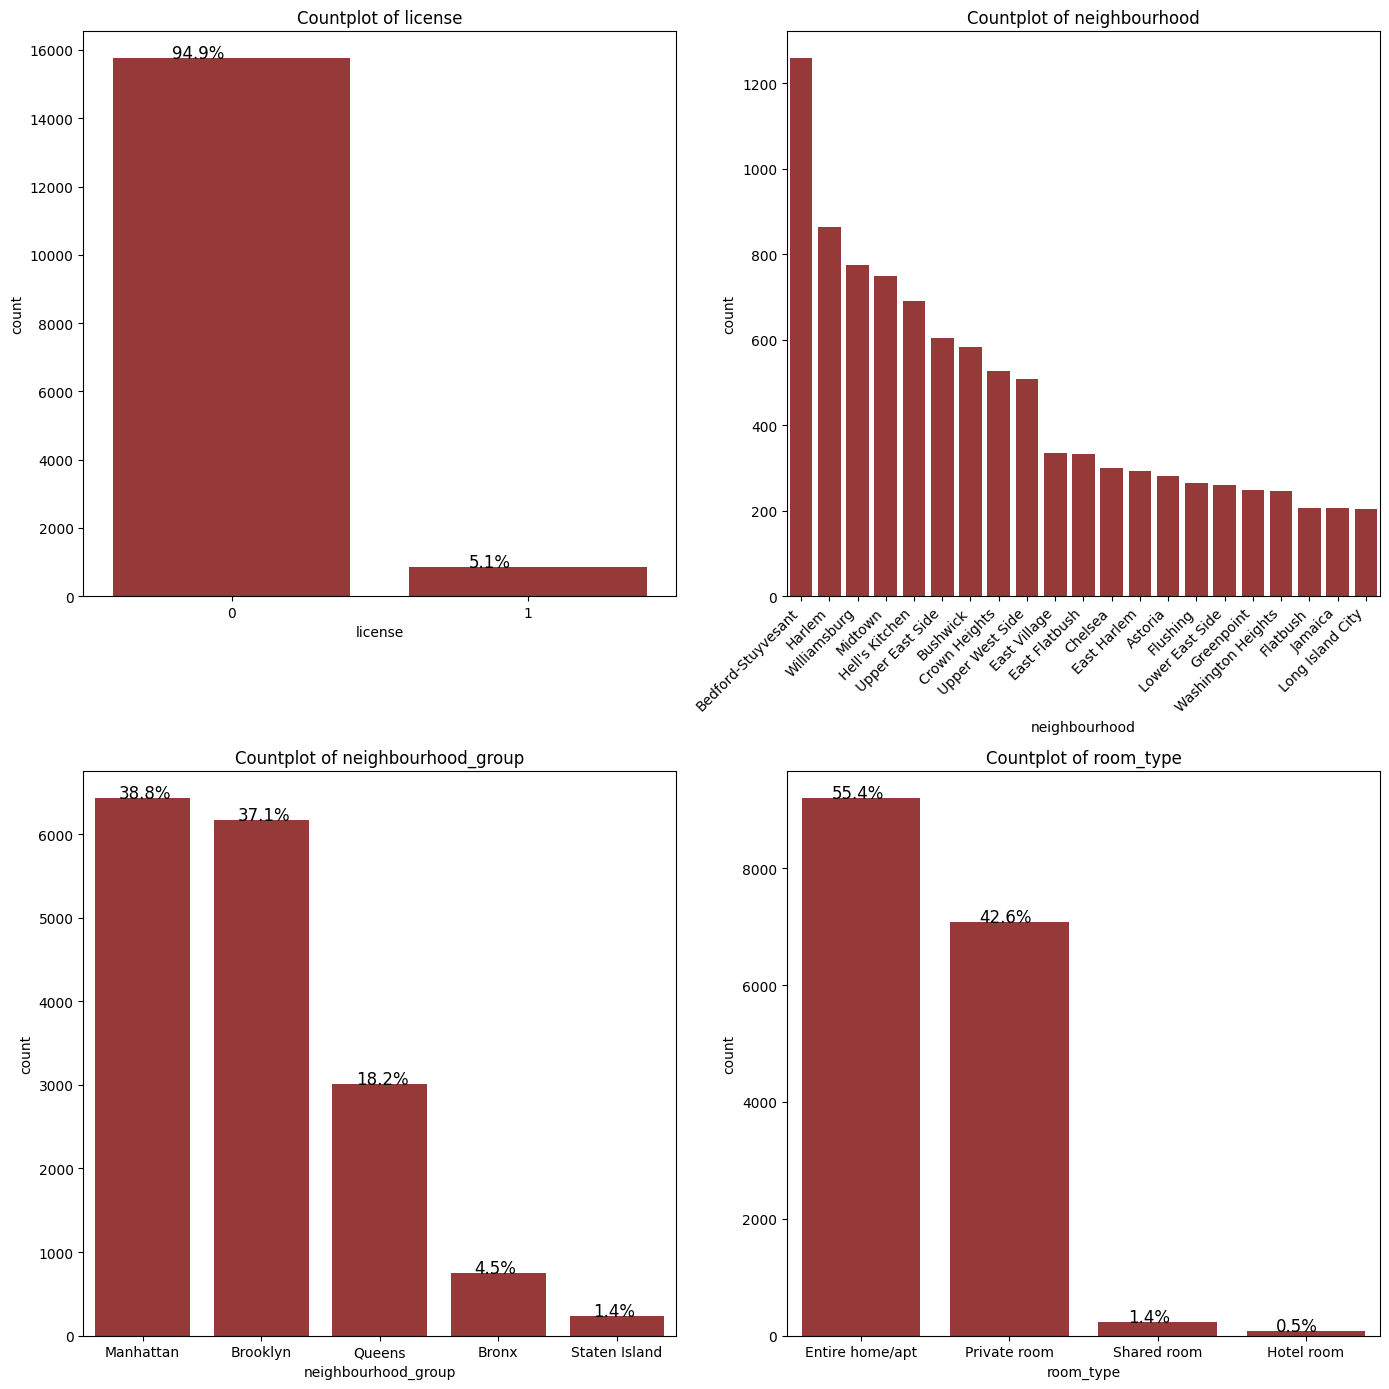

In [23]:
fig, axs = plt.subplots(2, 2, figsize = (14, 14))
axs = axs.flatten()

for i, col in enumerate(nonumerical):
    # Dla zmiennej neighbourhood wybieramy tylko te co mają nie mniej niż 200 występowań w ramce
    if col == "neighbourhood":
        series = data[col]
        counts = series.value_counts()
        series = series[series.isin(counts[counts>200].index)]
        fig = sns.countplot(x = series, ax = axs[i], color="brown", order=series.value_counts().index)
        fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
        axs[i].set(title = "Countplot of " + col)
    else:
        sns.countplot(data = data, x = col, ax = axs[i], color="brown", order=data[col].value_counts().index).set(title = "Countplot of " + col)
        
        without_hue(axs[i], data[col])
    

plt.tight_layout()
plt.show()

## 2.3 Zmiany po plottowaniu w ramce

In [24]:
# Zebrałem tu zmiany, które w następnych KM będzie można już od razu łatwiej implementować
# Trzeba pamiętac, że jeszcze był zmapowany license
def bath_mapper(a):
    if a == "Not specified":
        return 0
    else:
        return int(float(a))
def bedroom_mapper(a): # Uznałem, że posiadanie studio (czyli całe mieszkanie w jednym większym pokoju) to tak jakby była jedna sypialnia
    if a == "Studio":
        return 1
    else:
        return int(a)
def rating_mapper(a): # na razie tak może zostać
    if a == "New " or a == "No rating":
        return np.nan
    else:
        return float(a)
data["baths"] = data["baths"].map(bath_mapper)
data["bedrooms"] = data["bedrooms"].map(bedroom_mapper)
data["rating"] = data["rating"].map(rating_mapper)
data["last_review"] =  data["last_review"].map(np.datetime64) # Zmapowałem też date ostatniej opinii do przeznaczonego do tego typu
#data = data.drop(["name", "host_id", "host_name"], axis = 1) -> zrobilismy to wyzej + usunelismy id
data

neighbourhood_group       neighbourhood   latitude  longitude  \
0                  Queens           Ridgewood  40.702620 -73.898000   
1                Brooklyn        Williamsburg  40.720270 -73.955130   
2                Brooklyn  Bedford-Stuyvesant  40.686700 -73.948560   
3               Manhattan        East Village  40.732210 -73.986890   
4                Brooklyn         South Slope  40.668600 -73.987230   
...                   ...                 ...        ...        ...   
16601            Brooklyn  Bedford-Stuyvesant  40.686001 -73.943693   
16602              Queens              Corona  40.745100 -73.864880   
16603               Bronx            Allerton  40.867770 -73.860180   
16604           Manhattan              Harlem  40.830791 -73.949509   
16605           Manhattan             Midtown  40.762250 -73.978280   

             room_type  price  minimum_nights  number_of_reviews last_review  \
0      Entire home/apt  471.0              30                  1  2022-11-03   
1      Entire home/apt  225.0              30                 52  2023-09-13   
2         Private room   80.0              30                101  2023-11-17   
3      Entire home/apt   83.0              30                  2  2023-08-11   
4      Entire home/apt   90.0              30                479  2022-05-31   
...                ...    ...             ...                ...         ...   
16601  Entire home/apt  135.0              30                 15  2023-01-10   
16602     Private room   68.0              30                 16  2023-10-16   
16603  Entire home/apt  100.0              30                 30  2023-10-07   
16604     Private room   50.0              30                 19  2023-12-10   
16605  Entire home/apt  130.0              30                  2  2023-06-01   

       reviews_per_month  calculated_host_listings_count  availability_365  \
0                   0.07                               9               365   
1                   0.49                               5                90   
2                   1.00                               2               363   
3                   0.12                              30               106   
4                   2.90                               3               188   
...                  ...                             ...               ...   
16601               0.97                               1               262   
16602               2.68                               2               180   
16603               2.21                               5               365   
16604               0.21                               4                42   
16605               0.20                               5               365   

       number_of_reviews_ltm  license  rating  bedrooms  beds  baths  
0                          0        0     NaN         5     8      2  
1                          7        0    4.60         2     2      1  
2                         12        0    4.93         1     1      1  
3                          1        0     NaN         1     1      1  
4                          0        0    4.93         1     1      1  
...                      ...      ...     ...       ...   ...    ...  
16601                      1        0    4.87         3     3      1  
16602                     16        0    4.69         1     1      1  
16603                     24        0    4.73         1     1      1  
16604                      1        0    4.84         1     1      1  
16605                      2        0     NaN         1     1      1  

[16606 rows x 18 columns]

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16606 entries, 0 to 16605
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   neighbourhood_group             16606 non-null  object        
 1   neighbourhood                   16606 non-null  object        
 2   latitude                        16606 non-null  float64       
 3   longitude                       16606 non-null  float64       
 4   room_type                       16606 non-null  object        
 5   price                           16606 non-null  float64       
 6   minimum_nights                  16606 non-null  int64         
 7   number_of_reviews               16606 non-null  int64         
 8   last_review                     16606 non-null  datetime64[ns]
 9   reviews_per_month               16606 non-null  float64       
 10  calculated_host_listings_count  16606 non-null  int64         
 11  av

teraz wszystko jest w dobrych typach :)

## 2.4 Heatmapa po wyczyszczeniu ramki

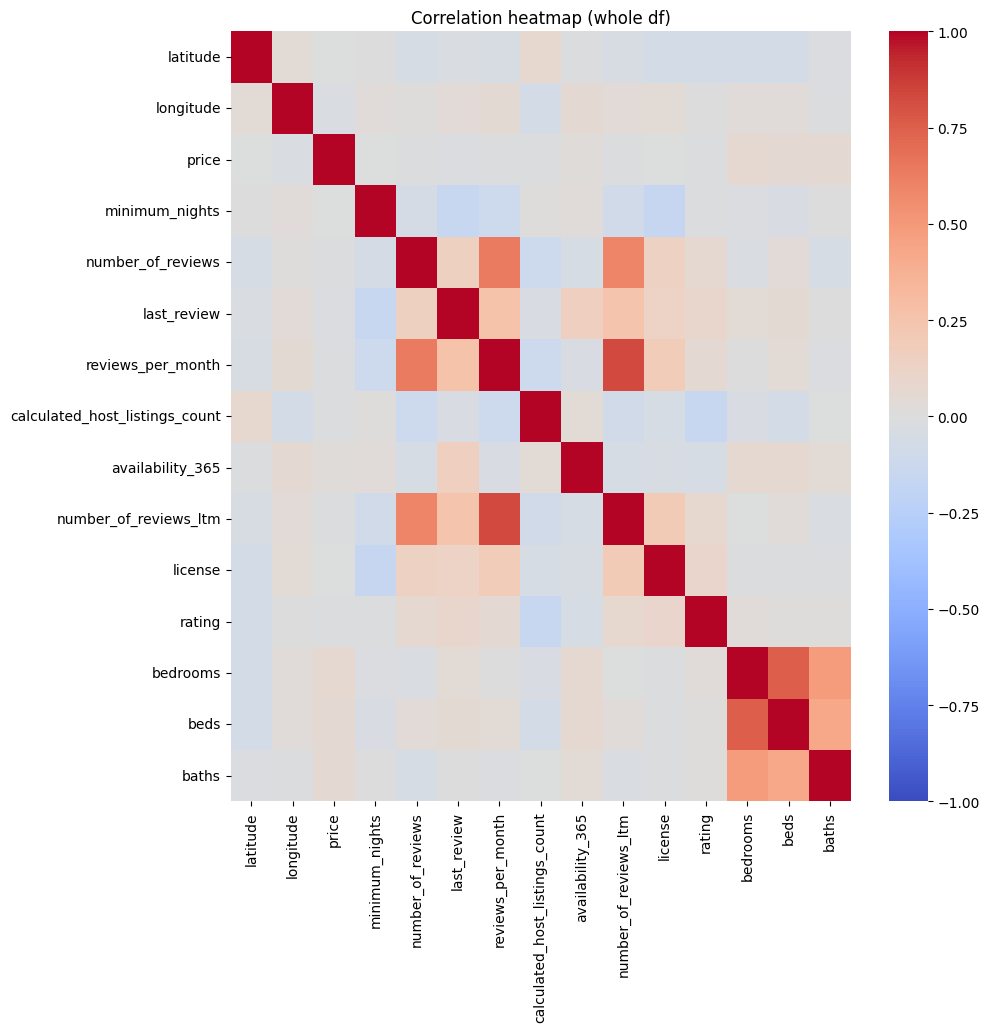

In [26]:
# Nic interesującego nie widać
plt.figure(figsize = (10, 10))
sns.heatmap(data.drop(["neighbourhood_group", "neighbourhood", "room_type"], axis = 1).corr(), cmap = 'coolwarm', center = 0, vmax = 1, vmin = -1).set(title = "Correlation heatmap (whole df)")
plt.show()

nic interesujacego tu nei mozemy zauwazyc

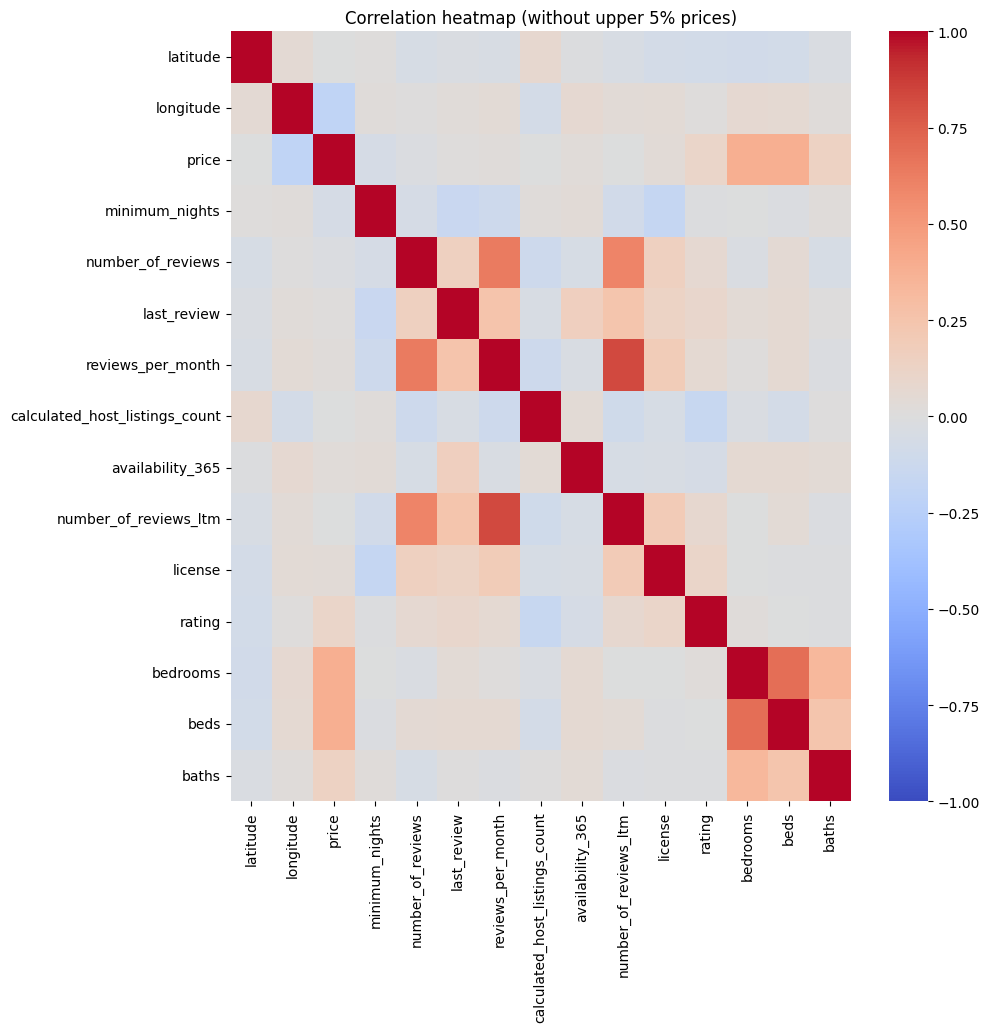

In [27]:
# Jeżeli usuniemy "nienormalne ceny" to mamy trochę lepszą wizję (ale dalej wsm nic)
plt.figure(figsize = (10, 10))
sns.heatmap(data.drop(["neighbourhood_group", "neighbourhood", "room_type"], axis = 1)[data["price"] <= np.quantile(data["price"], 0.95)].corr(), cmap = 'coolwarm', center = 0, vmax = 1, vmin = -1).set(title = "Correlation heatmap (without upper 5% prices)")
plt.show()

## 2.5 Wpływ zmiennych na cenę

Wyobrażając sobie sytuację, że robimy projekt z budowaniem modelu zajmującego się regresją cen... Poza tym te pomysły na wizualiację od razu się nasuwają

In [28]:
numerical = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'license', 'rating','bedrooms', 'beds', 'baths']

In [29]:
np.quantile(data["price"], 0.95)

430.0

In [30]:
# Do plotowania usuwam 5% obserwacji górnych price (dalej będe się głównie tą ramką posługiwał)
price_df = data[data["price"] <= np.quantile(data["price"], 0.95)]

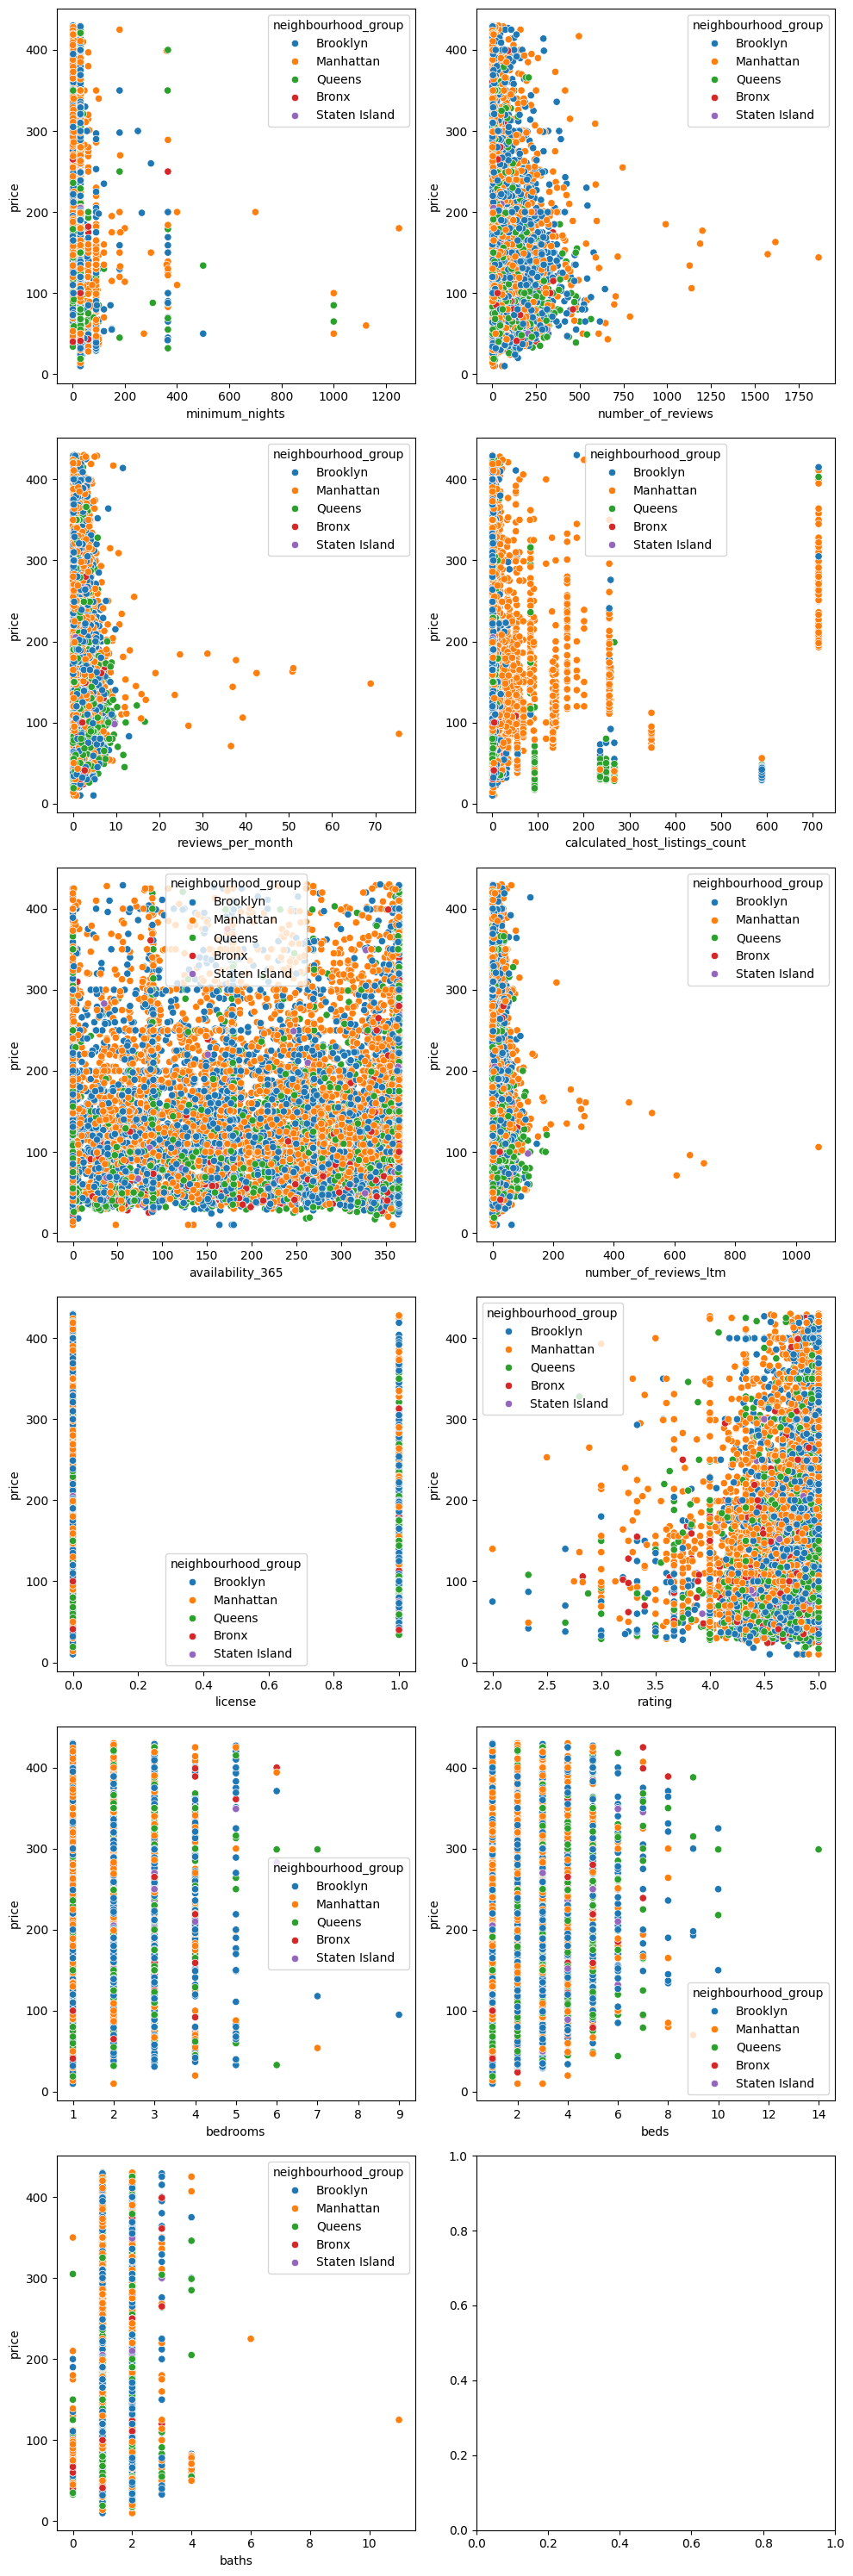

In [31]:
# No cóż punktów jest za dużo, aby sens miały scatter ploty, trzeba zrobić jakąś reprezentacje na heatmapach 
fig, axs = plt.subplots(6, 2, figsize = (10, 30))
axs = axs.flatten()
for i, col in enumerate(numerical):
    sns.scatterplot(data = price_df, y = "price", x = col, ax = axs[i], hue = "neighbourhood_group")
plt.tight_layout()
plt.show()

C:\Users\Bartek\AppData\Local\Temp\ipykernel_19344\1902588296.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  annot = df.groupby([col1, col2]).count().reset_index().pivot(index=col1, columns=col2, values="price").sort_index(ascending = False)
C:\Users\Bartek\AppData\Local\Temp\ipykernel_19344\1902588296.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby([col1, col2]).mean().reset_index().pivot(index=col1, columns=col2, values="price").sort_index(ascending = False)
C:\Users\Bartek\AppData\Local\Temp\ipykernel_19344\1902588296.py:15: FutureWarning: The default of observed=False is depreca

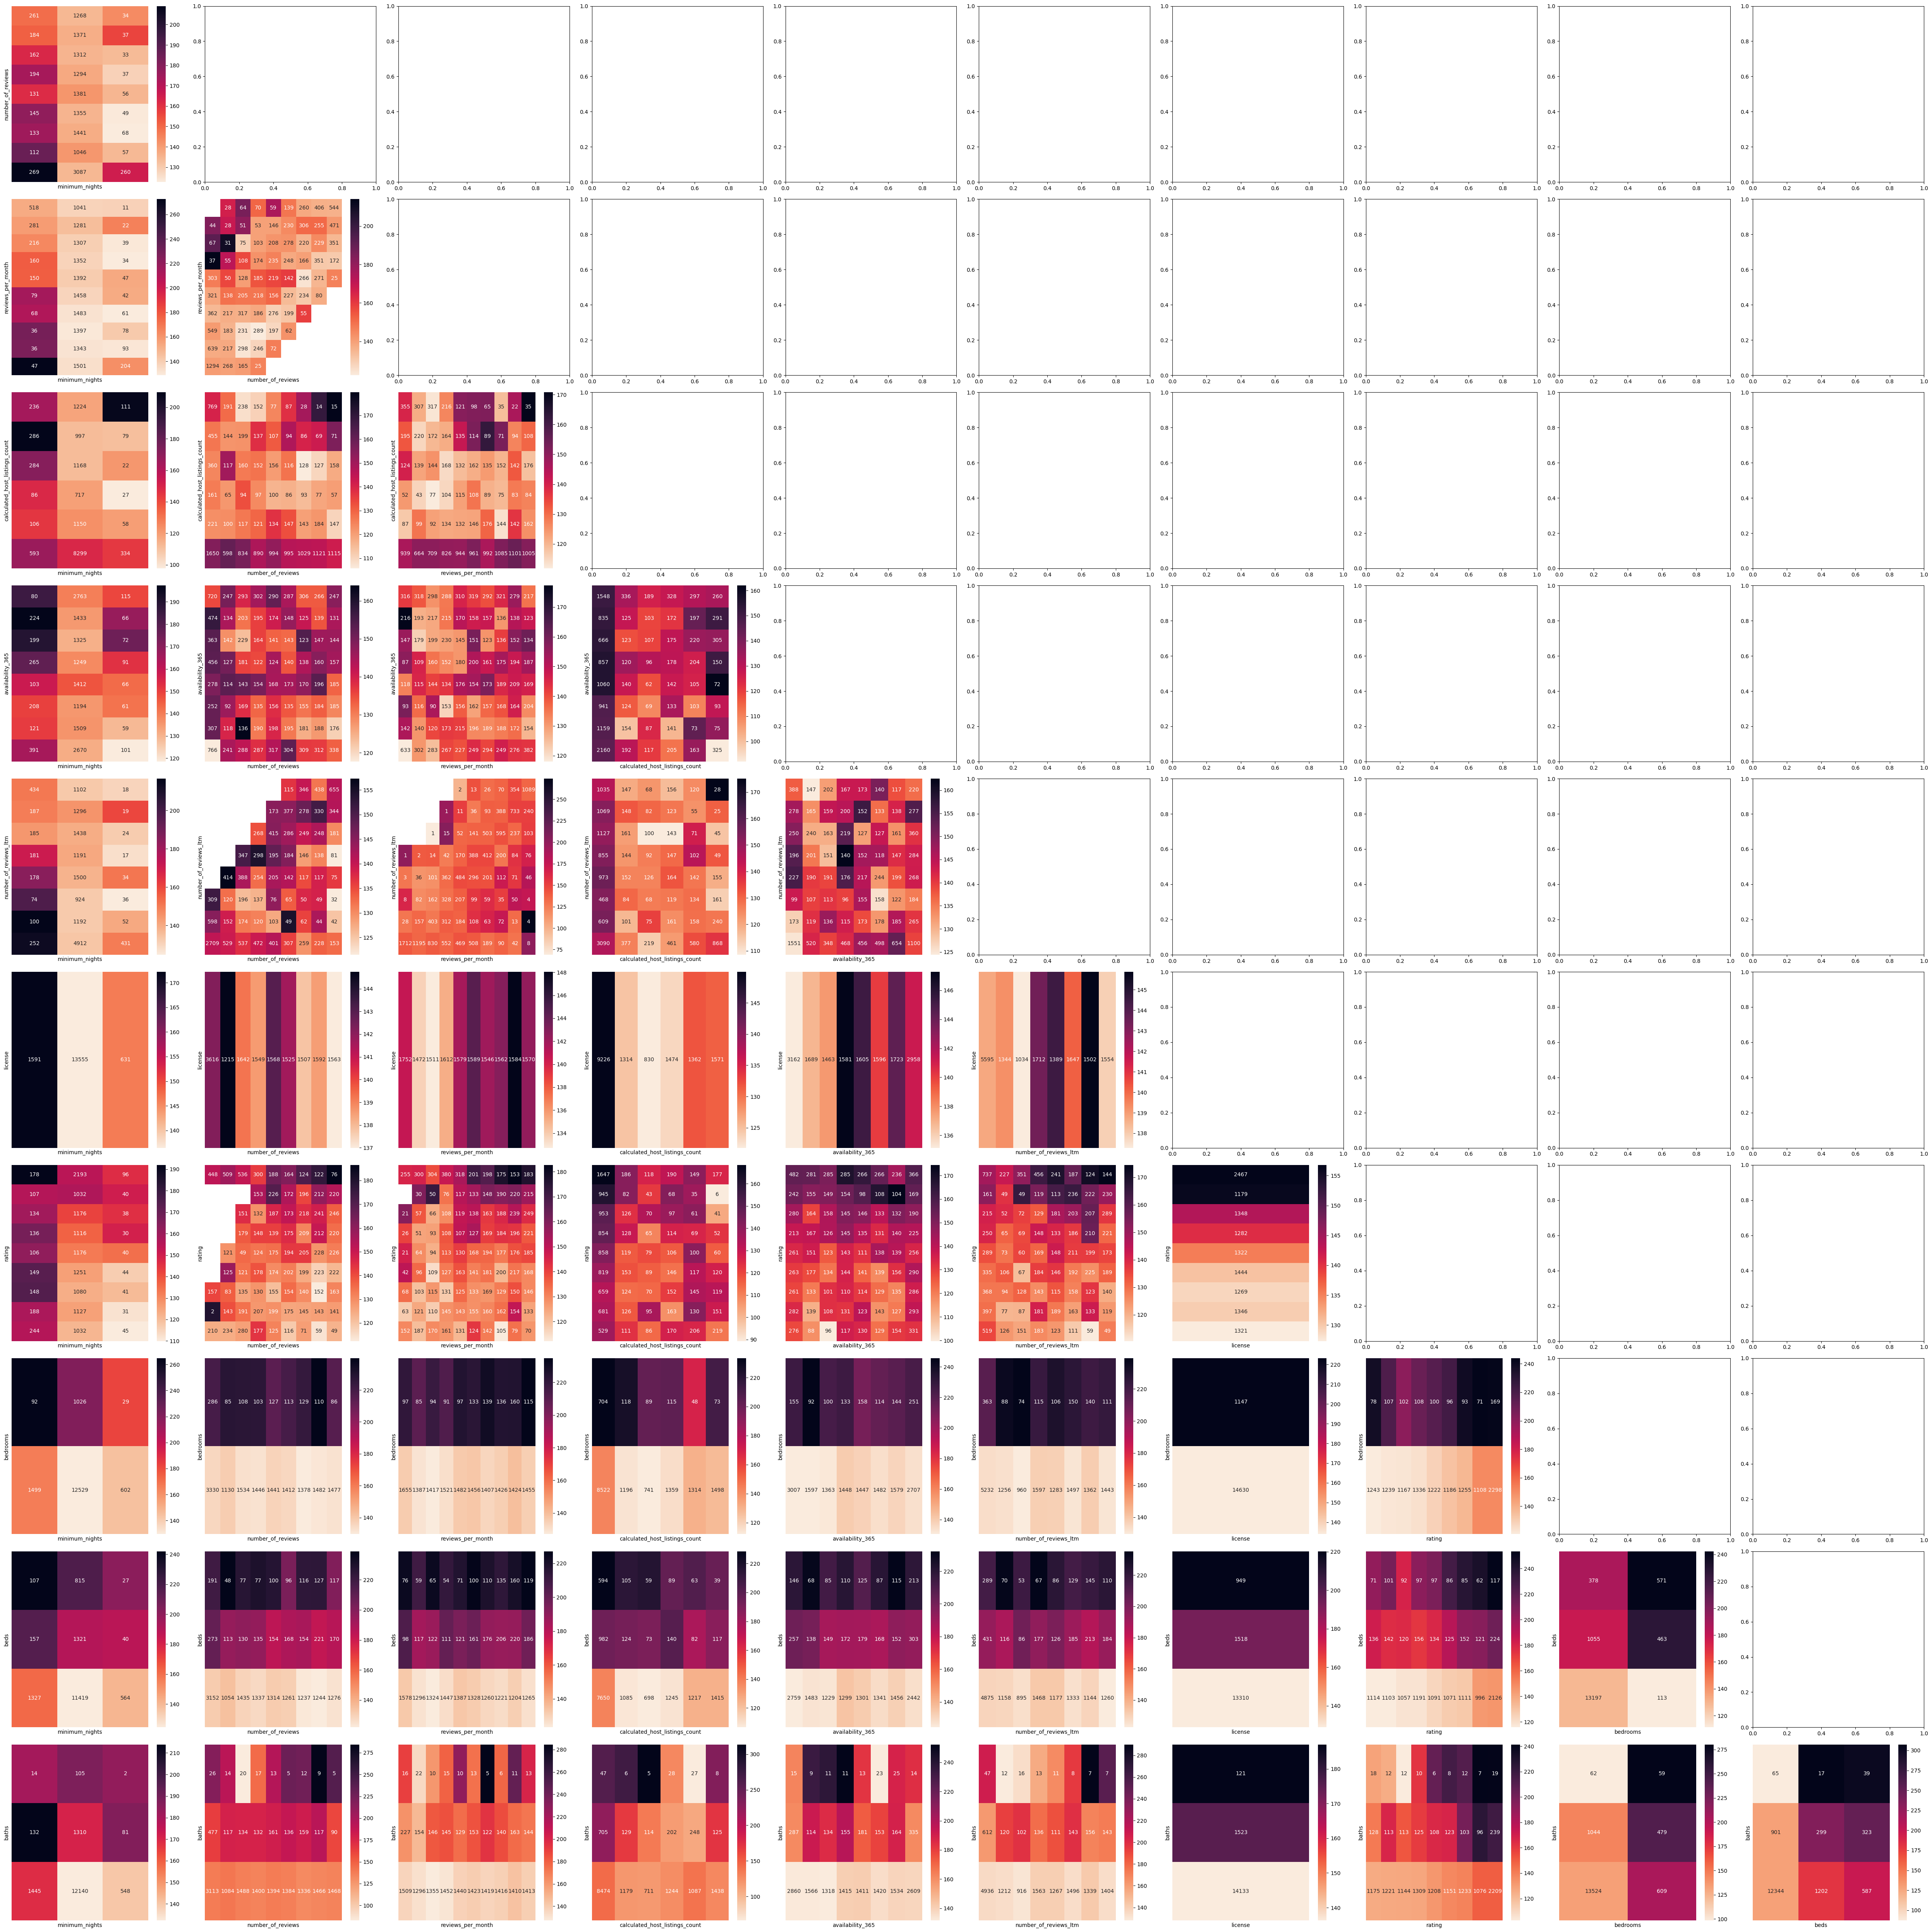

In [32]:
# Plot zapożyczony z poprzedniego projektu (W tym wypadku wpływ połączenia dwóch zmiennych numerycznych na cenę)
# Im ciemniejszy kwadrat tym wyższa jest średnia cena obserwacji danego kwadratu.
# Im bardziej w prawo lub im bardziej w górę tym wyższa wartość odpowiedniej zmiennej
# Wykres warto pobrać i tam sprawdzać jak wygląda na przybliżeniu
bins = 10
fig, axs = plt.subplots(10, 10, figsize = (50, 50))
fig.subplots_adjust(hspace = 0.4)

for i, col1 in enumerate(numerical):
    for j, col2 in enumerate(numerical):
        if j < i:
            df = pd.DataFrame({col1: pd.qcut(price_df[col1], q = bins, duplicates = "drop"),\
                  col2: pd.qcut(price_df[col2], q = bins, duplicates = "drop"),\
                  "price": price_df["price"].copy()})
            annot = df.groupby([col1, col2]).count().reset_index().pivot(index=col1, columns=col2, values="price").sort_index(ascending = False)
            df = df.groupby([col1, col2]).mean().reset_index().pivot(index=col1, columns=col2, values="price").sort_index(ascending = False)
            fig = sns.heatmap(df, cmap = sns.cm.rocket_r, ax = axs[i - 1][j], annot = annot, fmt='g')
            fig.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
plt.tight_layout()
plt.show()

#### Wpływ dzielnicy na cenę

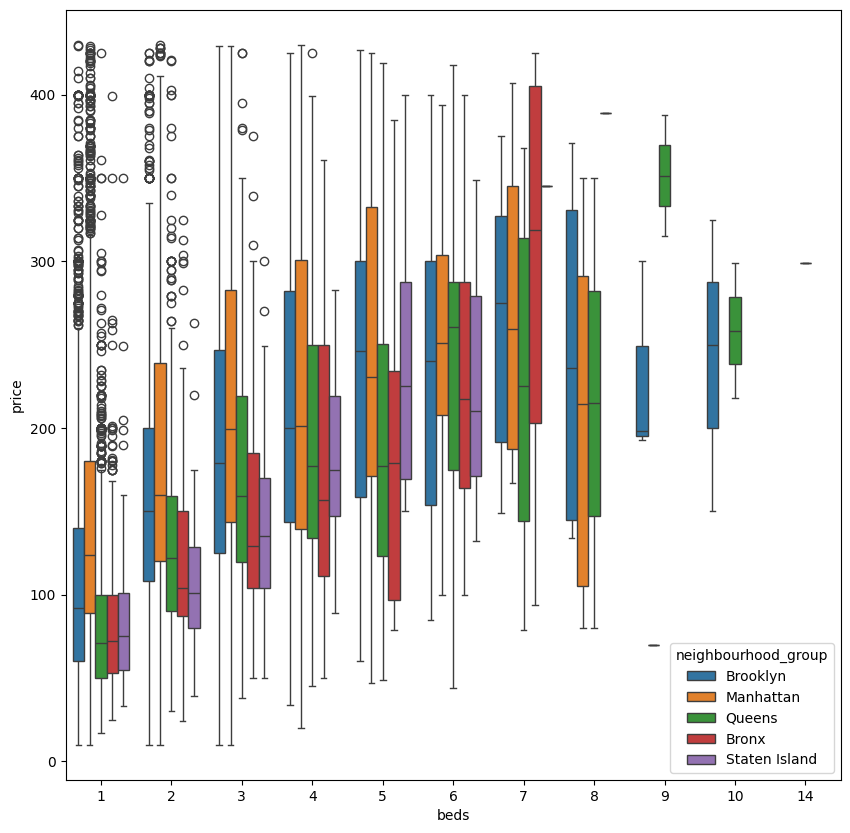

In [33]:
plt.figure(figsize = (10, 10))
sns.boxplot(data = price_df, y = "price", x = "beds", hue = "neighbourhood_group")
plt.show()

#### wplyw typu pokoju na cene

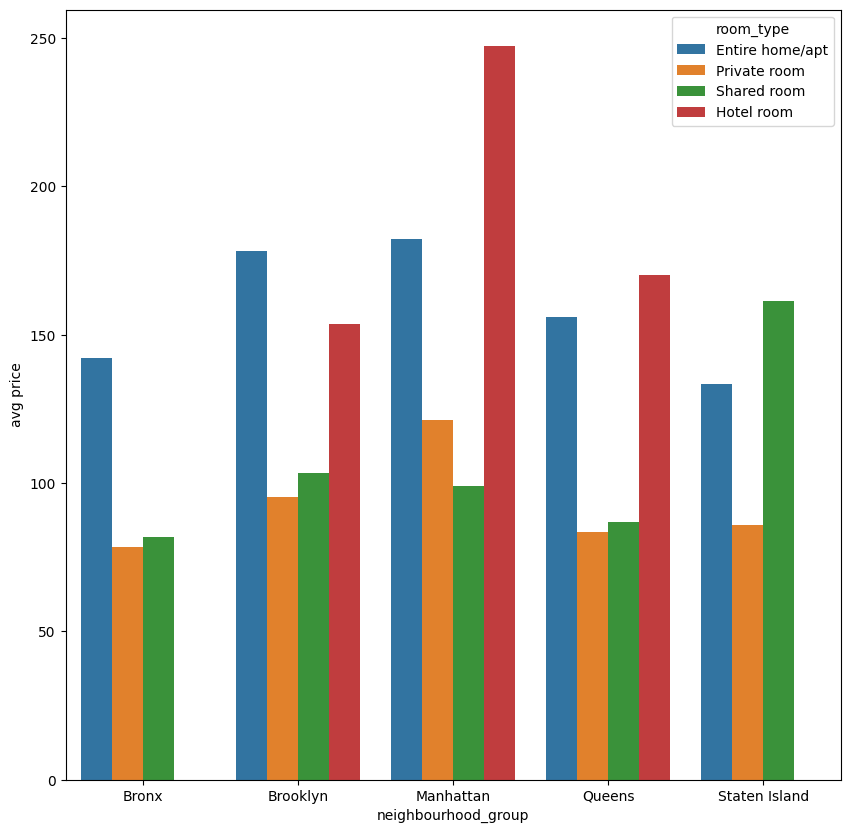

In [34]:
df = price_df[["price", "neighbourhood_group", 'room_type']].groupby(["neighbourhood_group", 'room_type']).mean().reset_index()

plt.figure(figsize = (10, 10))
ax = sns.barplot(data = df, y = "price", x = "neighbourhood_group", hue = "room_type")
ax.set(ylabel = "avg price")
plt.show()

#### Wpływ tego czy lokum ma licencje na cenę

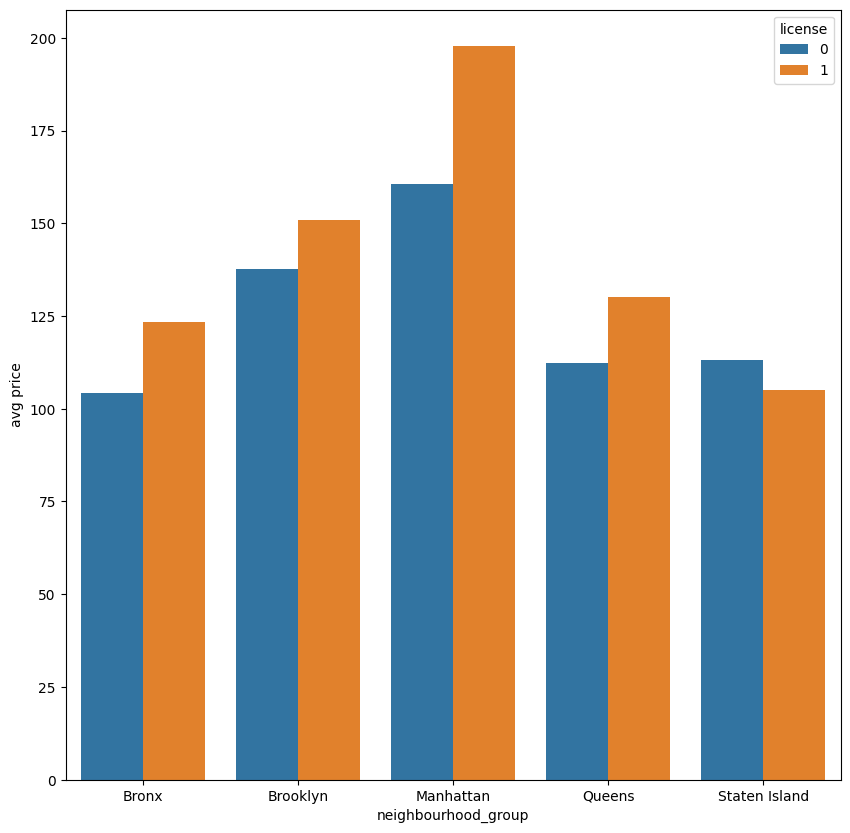

In [35]:
df = price_df[["price", "neighbourhood_group", 'license']].groupby(["neighbourhood_group", 'license']).mean().reset_index()

plt.figure(figsize = (10, 10))
ax = sns.barplot(data = df, y = "price", x = "neighbourhood_group", hue = "license")
ax.set(ylabel = "avg price")
plt.show()

#### Wpływ ilości opini na cenę

C:\Users\Bartek\AppData\Local\Temp\ipykernel_19344\744447061.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


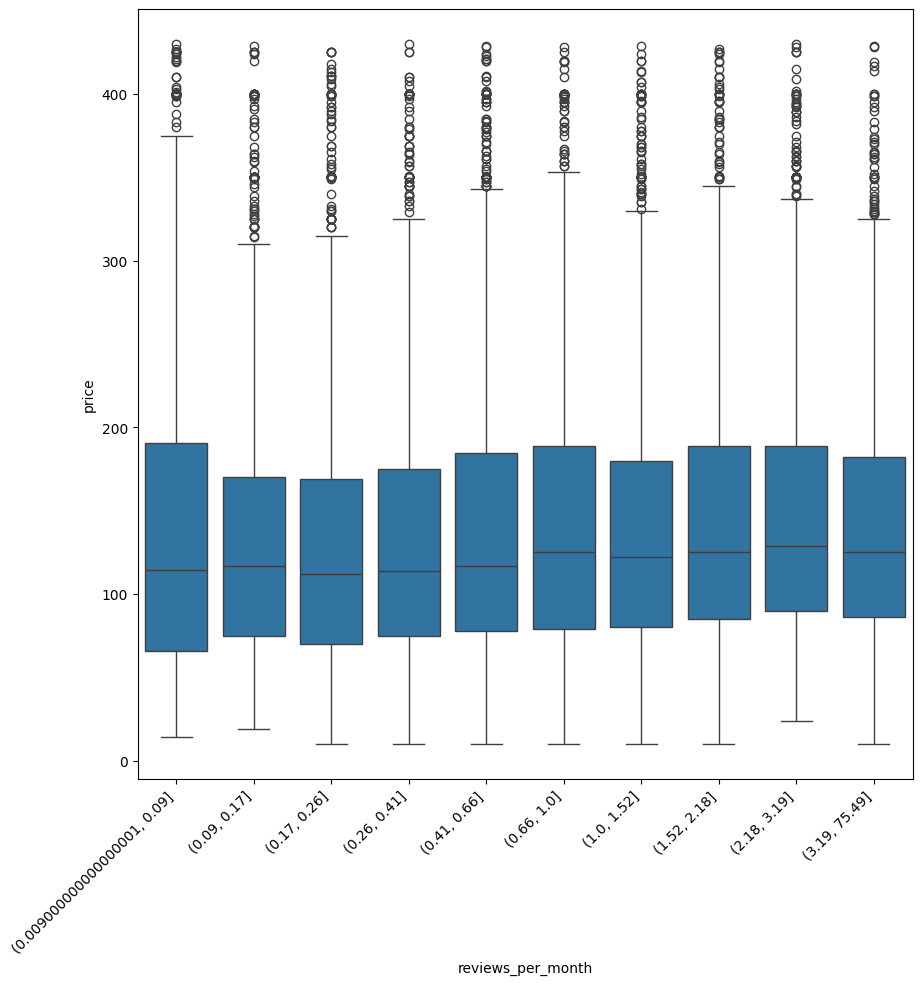

In [36]:
plt.figure(figsize = (10, 10))
ax = sns.boxplot(data = price_df, y = "price", x = pd.qcut(price_df["reviews_per_month"], q = 10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

#### Wpływ liosci spedzonych nocy na cenę

C:\Users\Bartek\AppData\Local\Temp\ipykernel_19344\3386389483.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


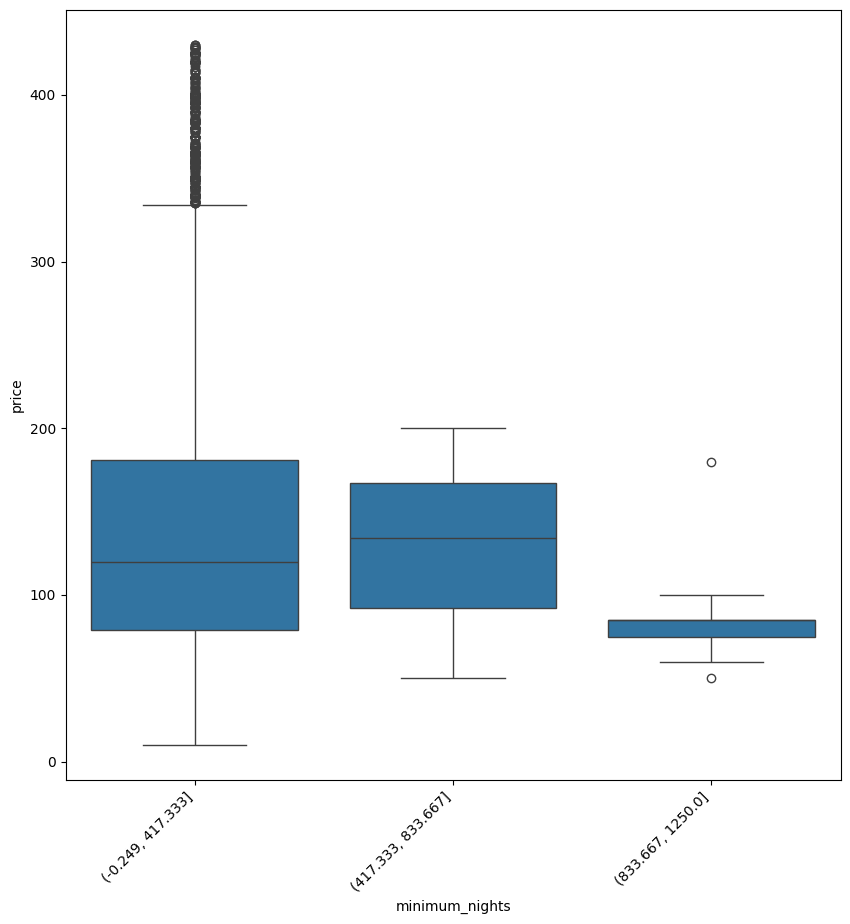

In [37]:
plt.figure(figsize = (10, 10))
ax = sns.boxplot(data = price_df, y = "price", x = pd.cut(price_df["minimum_nights"], bins = 3))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

## 2.6 Wpływ zmiennych na rating

#### dzielnica

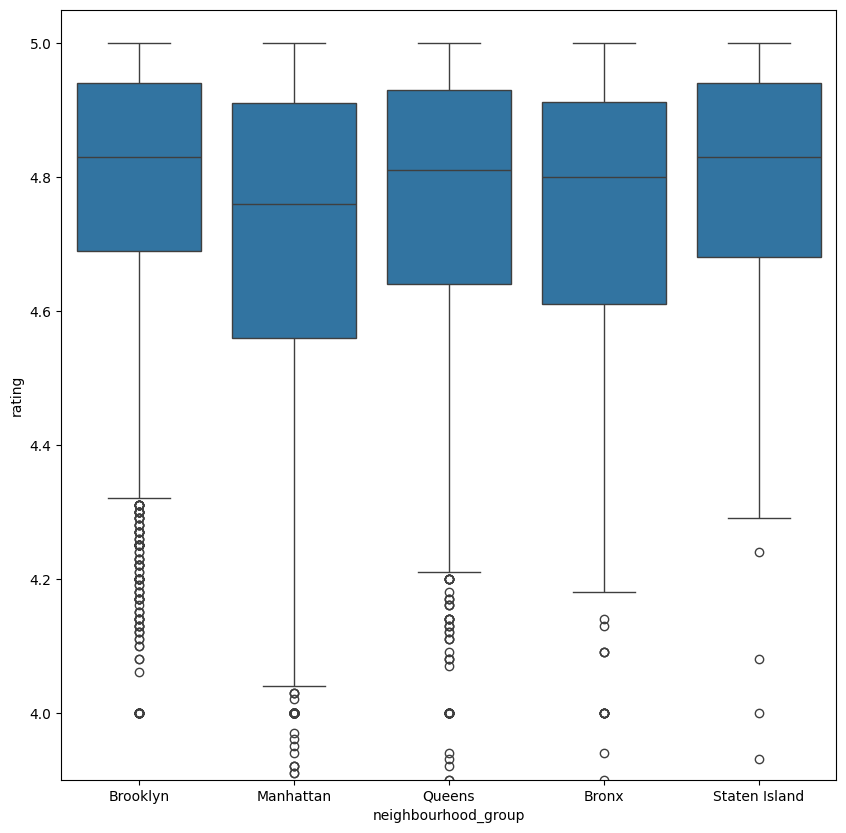

In [38]:
plt.figure(figsize = (10, 10))
sns.boxplot(data = price_df, y = "rating", x = "neighbourhood_group")
plt.ylim([3.9,5.05])
plt.show()

#### cena

C:\Users\Bartek\AppData\Local\Temp\ipykernel_19344\856118503.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


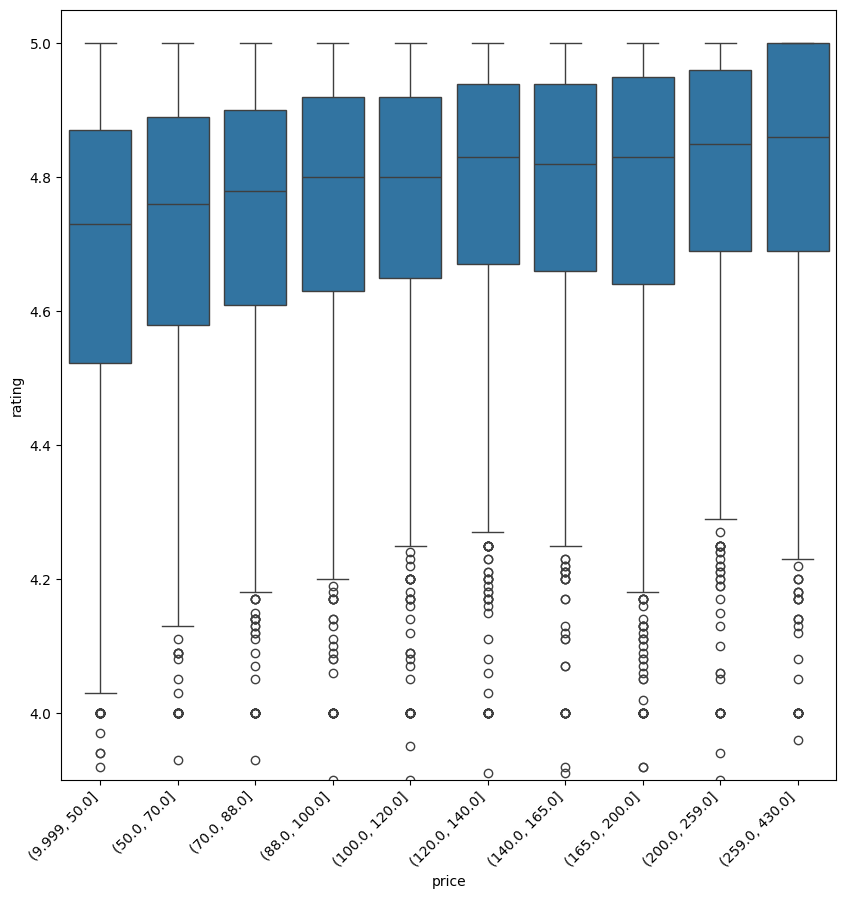

In [39]:
plt.figure(figsize = (10, 10))
ax = sns.boxplot(data = price_df, y = "rating", x = pd.qcut(price_df["price"], q = 10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylim([3.9,5.05])
plt.show()

#### cena i dzielnica

C:\Users\Bartek\AppData\Local\Temp\ipykernel_19344\2509617600.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


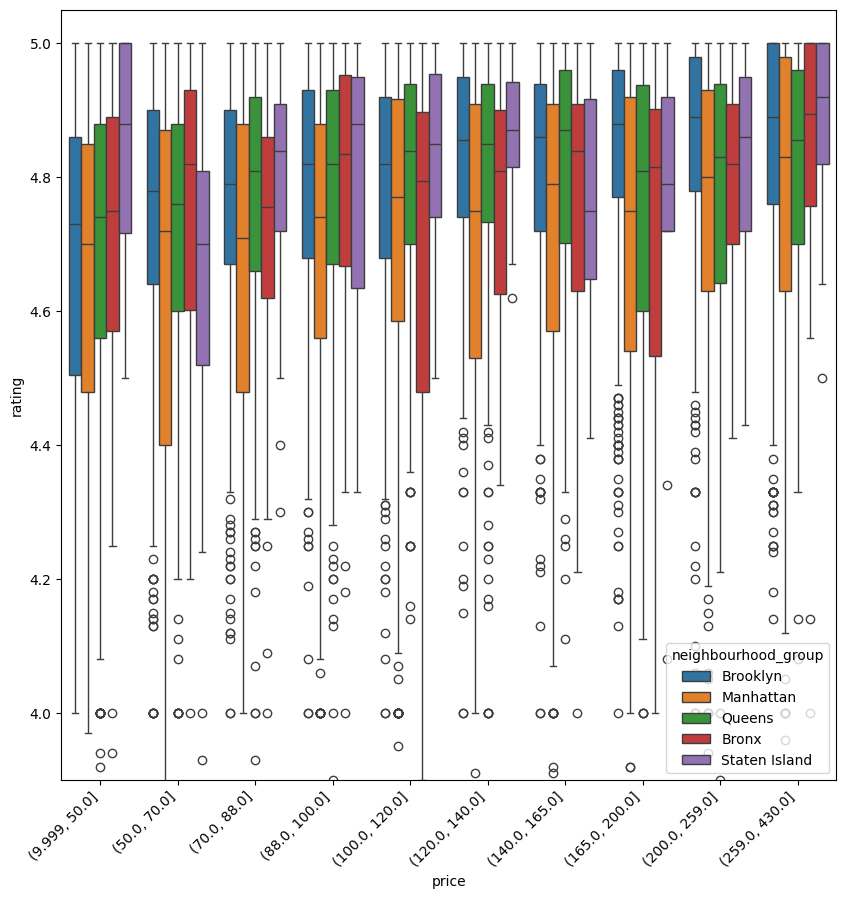

In [40]:
plt.figure(figsize = (10, 10))
ax = sns.boxplot(data = price_df, y = "rating", x = pd.qcut(price_df["price"], q = 10), hue = "neighbourhood_group")
sns.move_legend(ax, 'lower right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylim([3.9,5.05])
plt.show()

#### ilość opinii

C:\Users\Bartek\AppData\Local\Temp\ipykernel_19344\1038934962.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


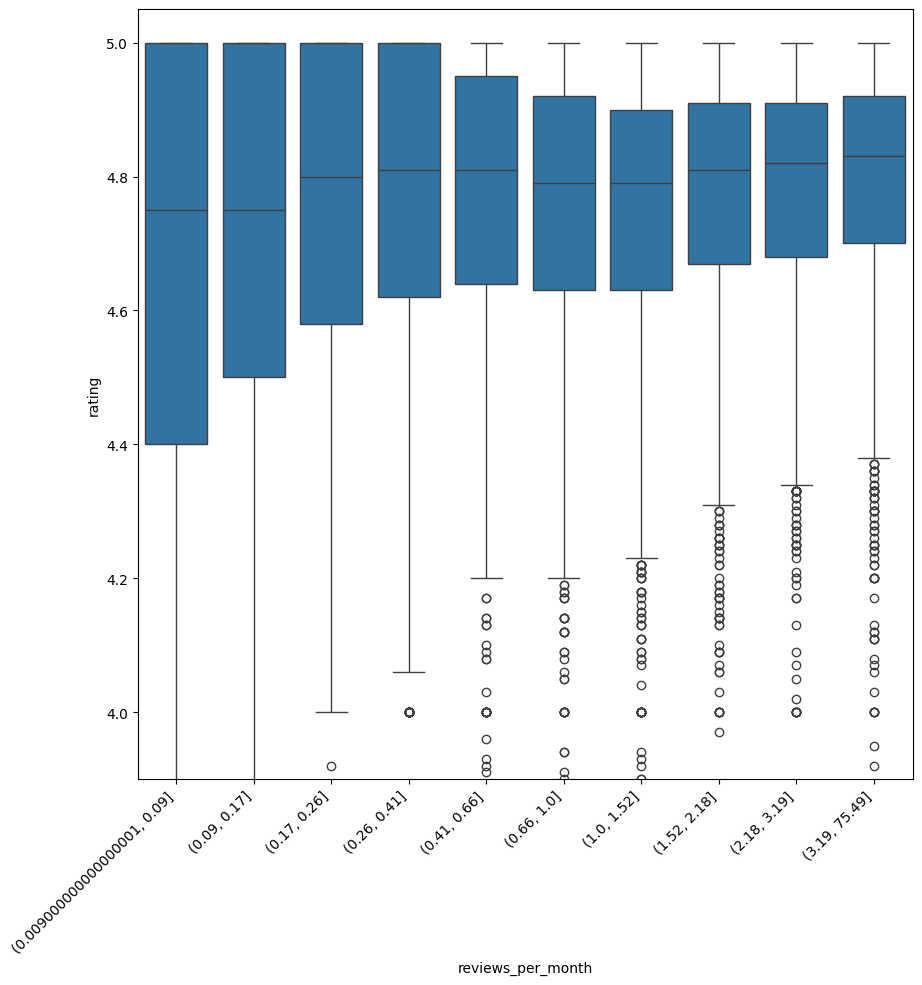

In [41]:
plt.figure(figsize = (10, 10))
ax = sns.boxplot(data = price_df, y = "rating", x = pd.qcut(price_df["reviews_per_month"], q = 10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylim([3.9,5.05])
plt.show()

# 3. Mapy

In [42]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'

Gdzie sa konkretne dzielnice w NY?

In [50]:
fig = px.scatter_mapbox(data,
                    lat="latitude", lon="longitude", color="neighbourhood_group",
                    zoom=10, height=800, width=1200)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
fig.write_image("fig_neigh.png")

Czy sąsiedztwa to takie "poddzielnice"? 

In [44]:
fig = px.scatter_mapbox(data,
                    lat="latitude", lon="longitude", color="neighbourhood",
                    zoom=10, height=800)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(showlegend = True)
fig.show()

Jak wygląda rozkład cen w NY? (patrzymy bez górnych 5%)

In [45]:
# Problem w tym, że im większe skupisko ogłoszeń w danym miejsu tym jaśniejsza jest obserwacja, dlatego plot uznaję za bezsensowny
# Wystarczy pobawić się parametrem radius
fig = px.density_mapbox(price_df,
                    lat="latitude", lon="longitude", z="price", radius = 2,
                    zoom=10, height=800)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [46]:
price_df.groupby("neighbourhood").count().reset_index()

neighbourhood  neighbourhood_group  latitude  longitude  room_type  \
0           Allerton                   28        28         28         28   
1      Arden Heights                    4         4          4          4   
2           Arrochar                   11        11         11         11   
3            Arverne                   48        48         48         48   
4            Astoria                  274       274        274        274   
..               ...                  ...       ...        ...        ...   
214  Windsor Terrace                   41        41         41         41   
215        Woodhaven                   55        55         55         55   
216         Woodlawn                    6         6          6          6   
217          Woodrow                    3         3          3          3   
218         Woodside                  141       141        141        141   

     price  minimum_nights  number_of_reviews  last_review  reviews_per_month  \
0       28              28                 28           28                 28   
1        4               4                  4            4                  4   
2       11              11                 11           11                 11   
3       48              48                 48           48                 48   
4      274             274                274          274                274   
..     ...             ...                ...          ...                ...   
214     41              41                 41           41                 41   
215     55              55                 55           55                 55   
216      6               6                  6            6                  6   
217      3               3                  3            3                  3   
218    141             141                141          141                141   

     calculated_host_listings_count  availability_365  number_of_reviews_ltm  \
0                                28                28                     28   
1                                 4                 4                      4   
2                                11                11                     11   
3                                48                48                     48   
4                               274               274                    274   
..                              ...               ...                    ...   
214                              41                41                     41   
215                              55                55                     55   
216                               6                 6                      6   
217                               3                 3                      3   
218                             141               141                    141   

     license  rating  bedrooms  beds  baths  
0         28      26        28    28     28  
1          4       4         4     4      4  
2         11       8        11    11     11  
3         48      43        48    48     48  
4        274     244       274   274    274  
..       ...     ...       ...   ...    ...  
214       41      35        41    41     41  
215       55      45        55    55     55  
216        6       5         6     6      6  
217        3       1         3     3      3  
218      141     105       141   141    141  

[219 rows x 18 columns]

In [51]:
# Pogrupujmy więc dane na te poddzielnice
# Wyliczymy średnią po wszystkich cechach (zmienne dotyczące położenia powinny wskazać środek tych poddzielnic)
df = price_df.drop(["neighbourhood_group", "room_type"], axis = 1).groupby("neighbourhood").mean().reset_index()
df["counts"] = price_df.drop(["neighbourhood_group", "room_type"], axis = 1).groupby("neighbourhood").count().reset_index()["latitude"]
fig = px.scatter_mapbox(df,
                    lat="latitude", lon="longitude",
                    size = "price", color = "rating", 
                    hover_name = "neighbourhood", hover_data = ["price", "rating", "counts"],
                    zoom=10, height=800, width = 1200, color_continuous_scale="bluered")
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(showlegend = False)
fig.show()
fig.write_image("fig_rat.png")

In [48]:
# Które dzielnice na topie? (mają największy rate opinii na miesiąc za poprzedni rok)
df = price_df.drop(["neighbourhood_group", "room_type"], axis = 1).groupby("neighbourhood").median().reset_index()
df["counts"] = price_df.drop(["neighbourhood_group", "room_type"], axis = 1).groupby("neighbourhood").count().reset_index()["latitude"]
fig = px.scatter_mapbox(df,
                    lat="latitude", lon="longitude",
                    size = "number_of_reviews_ltm", color = "rating", 
                    hover_name = "neighbourhood", hover_data = ["number_of_reviews_ltm", "rating", "counts"],
                    zoom=10, height=800, color_continuous_scale="bluered")
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(showlegend = False)
fig.show()